# Copula density
<br />

Shanshan Wang <br />
shanshan.wang@uni-due.de <br />
Dec. 3, 2021

## Contents

 

<div class="alert alert-block alert-info" style="margin-top: 20px; font-size: 14px">
<ol >
<li><a href="#ecp">Copula density</a><br/>
        1.1 <a href="#data">Sampling two correlated time series</a> <br/>
        1.2 <a href="#rank">Ranking of data</a><br/>
        1.3 <a href="#estimate">Estimating a copula density for sampling data </a><br/>
        1.4 <a href="#visualize">Visualizing copula densities </a><br/>
</li>
<li><a href="#gauss">Gaussian copula density</a></li>
</ol>
    
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

## <a name="ecp"></a>1 Empirical copula density 

### <a name="data"></a>1.1 Sampling two correlated time series 

In [2]:
def sampling_two_corr_time_series(mean: np.ndarray,
                                  cov: np.ndarray,
                                  n: int) -> pd.DataFrame:
    """Compute two correlated time series.
    Args:
        mean (np.ndarray): one dimensional array with the mean values of the
        two time series (i.e. np.array([1, 2])).
        cov (np.ndarray): two dimensional array with the diagonal covariances
        (i.e. np.array([[1, 1], [1, 2]]))
        n (int): length of the time series.
    Returns:
        pd.DataFrame: two correlated times series.
    """
    # Obtain the values of the correlated time series
    val = np.random.multivariate_normal(mean,cov,n)
    return pd.DataFrame(val, columns=['x', 'y'])

def draw_histogram(x: list,
                   n_bins: int,
                   label_x: str):
    # histograms of the data
    fig, axes=plt.subplots(figsize=(7,4))
    sns.histplot(data=x, bins=n_bins,stat='density').set(title='probability density distribution', xlabel=label_x,ylabel='pdf')
    #plt.savefig('hist_of_'+label_x+'.png',dpi=300, transparent=False, format='png', bbox_inches='tight')
    plt.show()

def draw_joint_distribution(z: pd.DataFrame,
                            label_x: str,
                            label_y: str):
    # joint distribution of x and y
    sns.jointplot(data=z, kind="scatter", x=label_x, y=label_y)
    #plt.savefig('joint_distribution.png',dpi=300, transparent=False, format='png', bbox_inches='tight')
    plt.show()

In [3]:
mean = (1, 2)
cov = [[1, 1], [1, 2]] # diagonal covariance
n=10000
z=sampling_two_corr_time_series(mean,cov,n)
x=z.x
y=z.y
z.head()

,x,y
0,1.766910,2.353329
1,1.473550,3.131102
2,1.236096,4.034073
3,2.493238,3.824737
4,1.828351,4.995001


In [4]:
print(np.corrcoef(z.to_numpy().T))

[[1.         0.70990553]
 [0.70990553 1.        ]]


In [5]:
print(np.cov(z.to_numpy().T))

[[0.99775103 1.00533175]
 [1.00533175 2.00999743]]


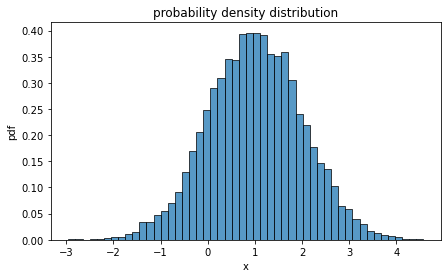

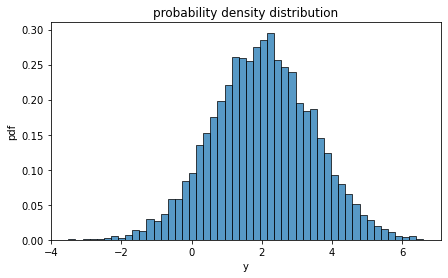

In [6]:
n_bins=50
label_x='x'
label_y='y'
draw_histogram(x,n_bins,label_x)
draw_histogram(y,n_bins,label_y)

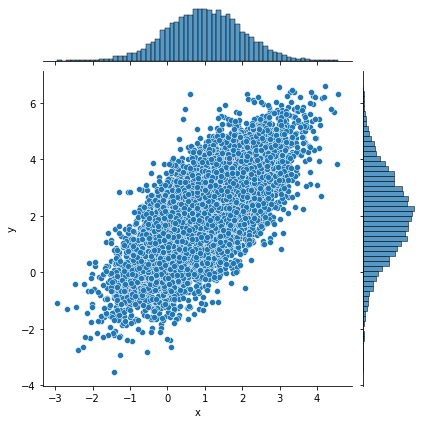

In [7]:
# joint distribution of x and y
draw_joint_distribution(z,label_x,label_y)

### <a name="rank"></a>1.2 Ranking of data

In [8]:
def qrank_data(x: list)->np.ndarray:
    # quantiles of ranks of variables x and y
    rx=ss.rankdata(x)
    qx=(rx-0.5)/len(x)
    return qx

In [9]:
# quantiles of ranks of variables x and y
qx=qrank_data(x)
qy=qrank_data(y)

In [10]:
# for example
a=[0.6,1,0.3,2,-0.5, 0.6]
rank=ss.rankdata(a)
quantile=(rank-0.5)/len(a)
print(rank,quantile)

[3.5 5.  2.  6.  1.  3.5] [0.5        0.75       0.25       0.91666667 0.08333333 0.5       ]


### <a name="estimate"></a>1.3 Estimating a copula density for sampling data 
It can be summarized as follows: make a 2d-histogram of the normalized quantiles of sampling data

In [11]:
def calc_copula_density(qx: np.ndarray,
                        qy: np.ndarray,
                        nx: int,
                        ny: int)-> np.ndarray:
    # calculate empirical copula density
    xmin=0
    xmax=1
    ymin=0
    ymax=1
    cop_dens=np.histogram2d(qx, qy, bins=(nx, ny), range=[[xmin, xmax], [ymin, ymax]],density=True)    # with density=True, normalize quantiles qx and qy
    return cop_dens[0]

In [12]:
# with density =True, normalize quantiles qx and qy
nx=20 # number of bins for qx
ny=20 # number of bins for qy
xmin=0 
xmax=1
ymin=0 
ymax=1
cop_den=calc_copula_density(qx,qy,nx,ny)

### <a name="visualize"></a>1.4 Visualizing copula densities 

In [13]:
def draw_heatmap(matrix: np.ndarray,
                 label_x: str,
                 label_y: str):
    # draw a two dimensional array in a heatmap
    fig=plt.figure(figsize=(8,6))
    nx=ny=len(matrix)
    xticklist=range(0,nx,2)
    xticklabels=[format(xt/nx,'.2f') for xt in xticklist]
    yticklist=range(0,ny,2)
    yticklabels=[format(yt/ny,'.2f') for yt in yticklist]
    sns.heatmap(matrix,cmap='jet').set(title='copula density', xlabel=label_x, ylabel=label_y, xticks=xticklist,yticks=yticklist, xticklabels=xticklabels, yticklabels=yticklabels);
    #plt.savefig('heatmap_cop_den.png',dpi=300, transparent=False, format='png', bbox_inches='tight')
    plt.show()

def draw_surface(matrix: np.ndarray,
                 label_x: str,
                 label_y: str):
    # draw the empirical copula density in a surface plot
    nx=ny=len(matrix)
    X, Y = np.meshgrid(range(nx), range(ny))
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection='3d')
    mycmap = plt.get_cmap('jet')
    surf1=ax.plot_surface(X, Y, matrix, cmap = mycmap)
    xticklist=range(0,nx,2)
    xticklabels=[format(xt/nx,'.2f') for xt in xticklist]
    yticklist=range(0,ny,2)
    yticklabels=[format(yt/ny,'.2f') for yt in yticklist]
    plt.xlabel('\n\n '+label_x)
    plt.ylabel('\n\n '+label_y)
    plt.xticks(xticklist,xticklabels,rotation=45)
    plt.yticks(yticklist,yticklabels,rotation=135)
    ax.set_zlabel('copula density')
    fig.colorbar(surf1, ax=ax, shrink=0.3, aspect=8)
    #plt.savefig('surface_cop_den.png',dpi=300, transparent=False, format='png', bbox_inches='tight')
    plt.show()

def draw_bar3d(matrix: np.ndarray,
                 label_x: str,
                 label_y: str):
    # draw copula density in 3-dimensional bar chart
    # Construct arrays for the anchor positions of the nx*ny bars.
    nx=ny=len(matrix)
    xpos, ypos = np.meshgrid(range(nx), range(ny))
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0
    # Construct arrays with the dimensions for the nx*ny bars.
    dx = dy = 1 * np.ones_like(zpos)
    dz = matrix.ravel()
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(projection='3d')
    colors = plt.cm.jet(matrix.flatten()/float(matrix.max()))
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=colors)
    xticklist=range(0,nx,2)
    xticklabels=[format(xt/nx,'.2f') for xt in xticklist]
    yticklist=range(0,ny,2)
    yticklabels=[format(yt/ny,'.2f') for yt in yticklist]
    plt.xlabel('\n\n '+label_x)
    plt.ylabel('\n\n '+label_y)
    plt.xticks(xticklist,xticklabels,rotation=45)
    plt.yticks(yticklist,yticklabels,rotation=135)
    ax.set_zlabel('copula density')
    #plt.savefig('bar3d_cop_den.png',dpi=300, transparent=False, format='png', bbox_inches='tight')
    plt.show()

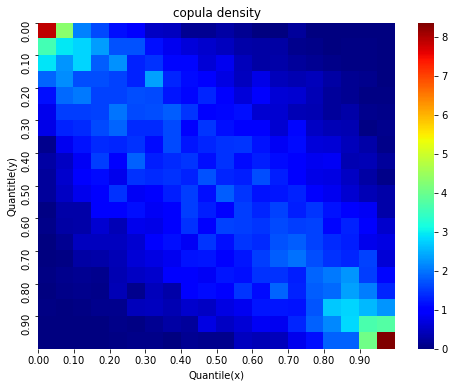

In [14]:
label_qx='Quantile(x)'
label_qy='Quantitle(y)'
draw_heatmap(cop_den,label_qx,label_qy)

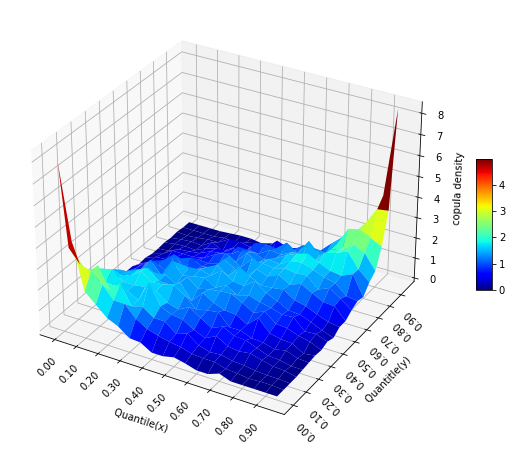

In [15]:
draw_surface(cop_den,label_qx,label_qy)

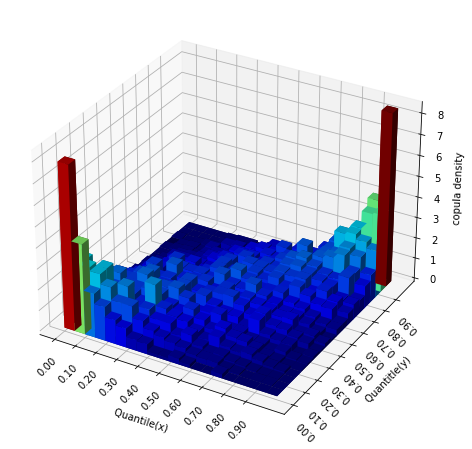

In [16]:
draw_bar3d(cop_den,label_qx,label_qy)

## <a name="gauss"></a> 2 Gaussian Copula Density 

One assumes that the random variables $x_1$ and $x_2$, normalized to zero mean and unit variance, follow a bivariate normal distribution with a correlation coefficient $c$. The bivariate cumulative normal distribution of $x_1$ and $x_2$ is given by
\begin{equation}
F(x_1,x_2)=\int\limits_{-\infty}^{x_1}\int\limits_{-\infty}^{x_2}\frac{1}{2\pi \sqrt{1-c^2}}\mathrm{exp}\left(-\frac{y_1^2+y_2^2-2cy_1y_2}{2(1-c^2)} \right) dy_2dy_1 \ .
\label{eq4.2.1}
\end{equation}
Hence, the marginal cumulative normal distribution of $x_1$ is 
\begin{equation}
F_k(x_1)=\int\limits_{-\infty}^{x_1}\frac{1}{\sqrt{2\pi}}\mathrm{exp}\left(-\frac{y_1^2}{2} \right) dy_1 \ ,
\label{eq4.2.2}
\end{equation} 
and analogously for $F_l(x_2)$. The inverse cumulative distribution function $F_k^{-1}(\cdot)$ is known as the quantile function. We thus have
\begin{equation}
q_1=F_k(x_1) \quad \mathrm{and}\quad   x_1=F_k^{-1}(q_1) \ .
\label{eq3.1.3}
\end{equation}


The copula density is given as the two-fold derivative
\begin{equation}
\mathrm{cop}_{kl}(q_1,q_2)=\frac{\partial ^2}{\partial q_1\partial q_2}\mathrm{Cop}_{kl}(q_1,q_2) \ 
\label{eq3.1.5} 
\end{equation}
with respect to the quantiles $q_1, q_2 \in[0,1]$ . By carrying out the partial derivatives in the above equation, we can obtain an explicit expression of the Gaussian copula density 
\begin{eqnarray} \nonumber
\mathrm{cop}_{c}^G(q_1,q_2)=\frac{1}{\sqrt{1-c^2}}\mathrm{exp}\left(-\frac{c^2F_k^{-1}(q_1)^2+c^2F_l^{-1}(q_2)^2-2cF_k^{-1}(q_1)F_l^{-1}(q_2)}{2(1-c^2)}\right) \ 
\label{eq4.2.3}
\end{eqnarray}

<br/>

Ref. Shanshan Wang and Thomas Guhr, Local Fluctuations of the Signed Traded Volumes and the Dependencies of Demands: A Copula Analysis, [J. Stat. Mech. 2018, 033407 (2018)](http://stacks.iop.org/1742-5468/2018/i=3/a=033407),   preprint: [arXiv:1706.09240](http://arxiv.org/abs/1706.09240).


In [17]:
def GaussianCopulaDensity(q: list,
                          c: float)-> np.ndarray:
    # input quantiles q (0<q<1) and correlation coefficent c (0<q<1)    
    # calculate normal inverse cumulative distribution function
    x=ss.norm.ppf(q, loc=0, scale=1).tolist()
    # calcualte gaussian copula density
    cop=np.zeros([len(q), len(q)])
    for i, x1 in enumerate(x):
        for j, x2 in enumerate(x):
            cop[i,j]=np.exp(-(pow(c*x1,2)+pow(c*x2,2)-2*c*x1*x2)/(2*(1-pow(c,2))))/np.sqrt(1-pow(c,2))
    return cop
     

In [18]:
numbin=20
# calculate the quantile of bins
q=((np.arange(1, numbin+1, 1)-0.5)/20).tolist()
c=0.7
copG=GaussianCopulaDensity(q,c)
 

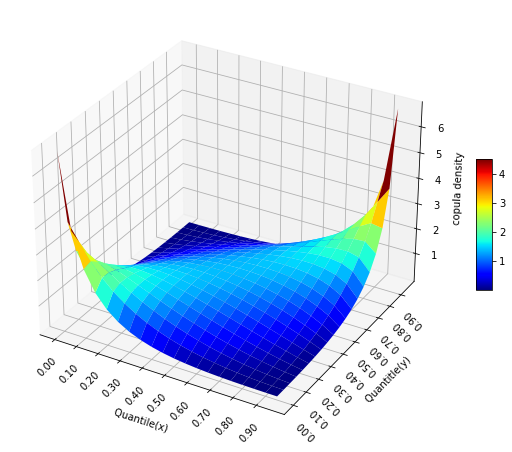

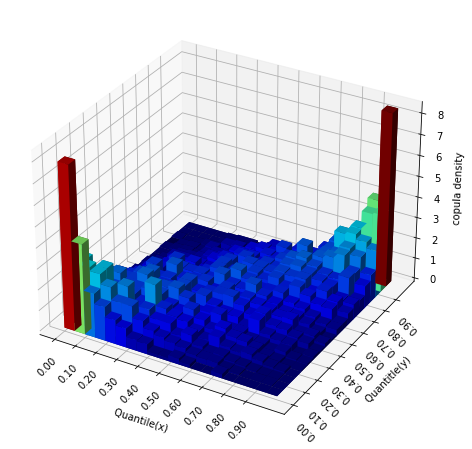

In [19]:
draw_surface(copG,label_qx,label_qy)
draw_bar3d(copG,label_qx,label_qy)